## ***네이버 종목토론방 크롤링(1개)**
1. 갭상승 종목 확인
2. 그 종목의 종목토론방 크롤링

Import Library

In [16]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup as bs
import requests
import urllib.request
import json
import itertools

### **1. 네이버 금융에서 갭상승 주식 리스트 뽑기(0908)**


In [17]:
# 네이버 금융->국내주식 페이지
url = "https://finance.naver.com/sise/"

# 웹사이트 정보 요청
stocks = requests.get(url)
soup = bs(stocks.text)
# soup

print(soup) 실행 시


---


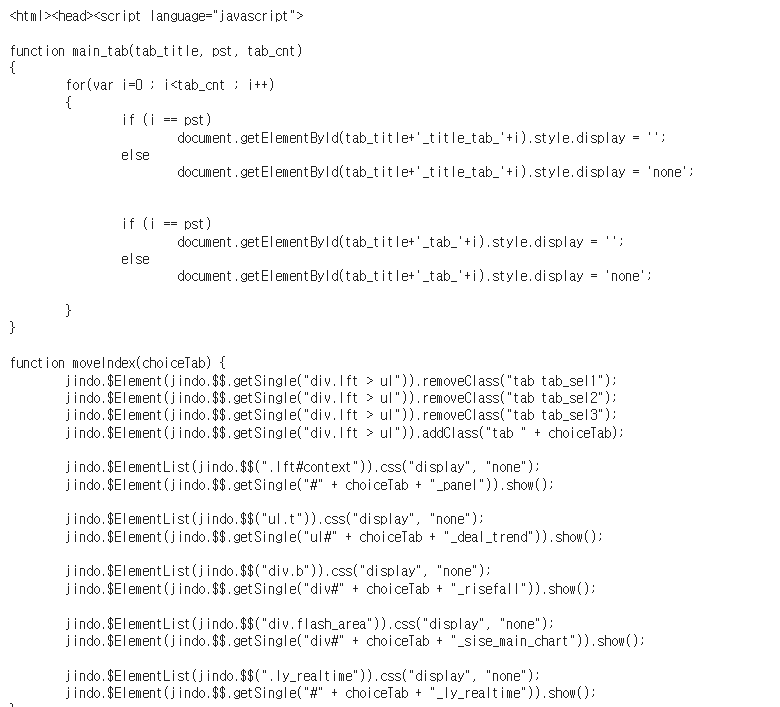


---



In [18]:
#  갭상승 리스트, 골든크로스 리스트
# soup.select('table.type_r1 tr a')
soup.select('table.type_r1 tr a')

[<a href="/item/main.naver?code=003580" onclick="clickcr(this, 'rgt.list1', '003580', '1', event)">HLB글로벌</a>,
 <a href="/item/main.naver?code=047920" onclick="clickcr(this, 'rgt.list1', '047920', '2', event)">HLB제약</a>,
 <a href="/item/main.naver?code=004910" onclick="clickcr(this, 'rgt.list1', '004910', '3', event)">조광페인트</a>,
 <a href="/item/main.naver?code=079810" onclick="clickcr(this, 'rgt.list1', '079810', '4', event)">디이엔티</a>,
 <a href="/item/main.naver?code=348370" onclick="clickcr(this, 'rgt.list1', '348370', '5', event)">엔켐</a>,
 <a href="/item/main.naver?code=580026" onclick="clickcr(this, 'rgt.list1', '580026', '6', event)">KB 레버리지 은 선물 ETN(H)</a>,
 <a href="/item/main.naver?code=530061" onclick="clickcr(this, 'rgt.list1', '530061', '7', event)">삼성 레버리지 은 선물 ETN(H)</a>,
 <a href="/item/main.naver?code=550064" onclick="clickcr(this, 'rgt.list1', '550064', '8', event)">QV 레버리지 은 선물 ETN(H)</a>,
 <a href="/item/main.naver?code=066970" onclick="clickcr(this, 'rgt.list1', '0669

#### **1.1 a onclick 값(""사이에 갇혀있음)만 불러오기**
종목코드, 순위 뽑기

In [19]:
links = soup.select('table.type_r1 tr a') # 모든 a 태그 추출
cell_line = []

for i in links:
    onclick = i.attrs['onclick']
    
    if 'rgt.list1' in onclick:  # rgt.list1: 갭상승 리스트, rgt.list2: 골든크로스 리스트
        cell_line.append(onclick)

print(cell_line)

["clickcr(this, 'rgt.list1', '003580', '1', event)", "clickcr(this, 'rgt.list1', '047920', '2', event)", "clickcr(this, 'rgt.list1', '004910', '3', event)", "clickcr(this, 'rgt.list1', '079810', '4', event)", "clickcr(this, 'rgt.list1', '348370', '5', event)", "clickcr(this, 'rgt.list1', '580026', '6', event)", "clickcr(this, 'rgt.list1', '530061', '7', event)", "clickcr(this, 'rgt.list1', '550064', '8', event)", "clickcr(this, 'rgt.list1', '066970', '9', event)", "clickcr(this, 'rgt.list1', '610016', '10', event)"]


In [20]:
# 종목코드 인덱스 찾기
print(cell_line[0][28:34]) # 1의 인덱스: 28. 종목 코드 인덱스 28~33까지

003580


In [21]:
df_list = []

for i, stock in enumerate(soup.select('table.type_r1 tr a')):
    rank_num = i+1
    stock_code = cell_line[i][28:34]
    stock_name = stock.text

    tmp_row = {'gap_rank': rank_num,
               'stock_code' : stock_code,
                'stock_name' : stock_name,
              }
        
    df_list.append(tmp_row)  # feature와 데이터로 묶인 딕셔너리 tmp_row를 데이터프레임에 추가
    
    if i+1 == len(cell_line):
        break
    
df = pd.DataFrame(df_list)
df

,gap_rank,stock_code,stock_name
0,1,003580,HLB글로벌
1,2,047920,HLB제약
2,3,004910,조광페인트
3,4,079810,디이엔티
4,5,348370,엔켐
5,6,580026,KB 레버리지 은 선물 ETN(H)
6,7,530061,삼성 레버리지 은 선물 ETN(H)
7,8,550064,QV 레버리지 은 선물 ETN(H)
8,9,066970,엘앤에프
9,10,610016,메리츠 레버리지 은 선물 ETN(H)


### **2. 갭상승 주식의 종목토론방에서 어그로를 잘 끄는 제목은?**

In [22]:
# 종목 조회 url: https://finance.naver.com/item/board.naver?code=101670&page=1
board_url = 'https://finance.naver.com/item/board.naver'
params_dict = {'code':'101670',
              'page': '1'}

headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}

board = requests.get(board_url, headers=headers)
print(board.text[:400])

<script type="text/javascript">
function doSearch() {
	var frm = document.boardSearchFrm;
	var str = frm.sw.value;
	str = str.replace(/^\s*/,'').replace(/\s*$/,'');	// trim
	
	if(str == '') {
		alert("검색어를 입력해 주세요.");
		frm.sw.value = '';
		frm.sw.focus();
	}
	else {
		frm.sw.value = str;
		frm.submit();
	}
}
</script>

<!--  global include -->

	

<html lang='ko'>
<head>


	
		<title> : 네이버 금융</t


In [23]:
board_soup= bs(board.text, 'html.parser')
# board_soup

board_soup 실행
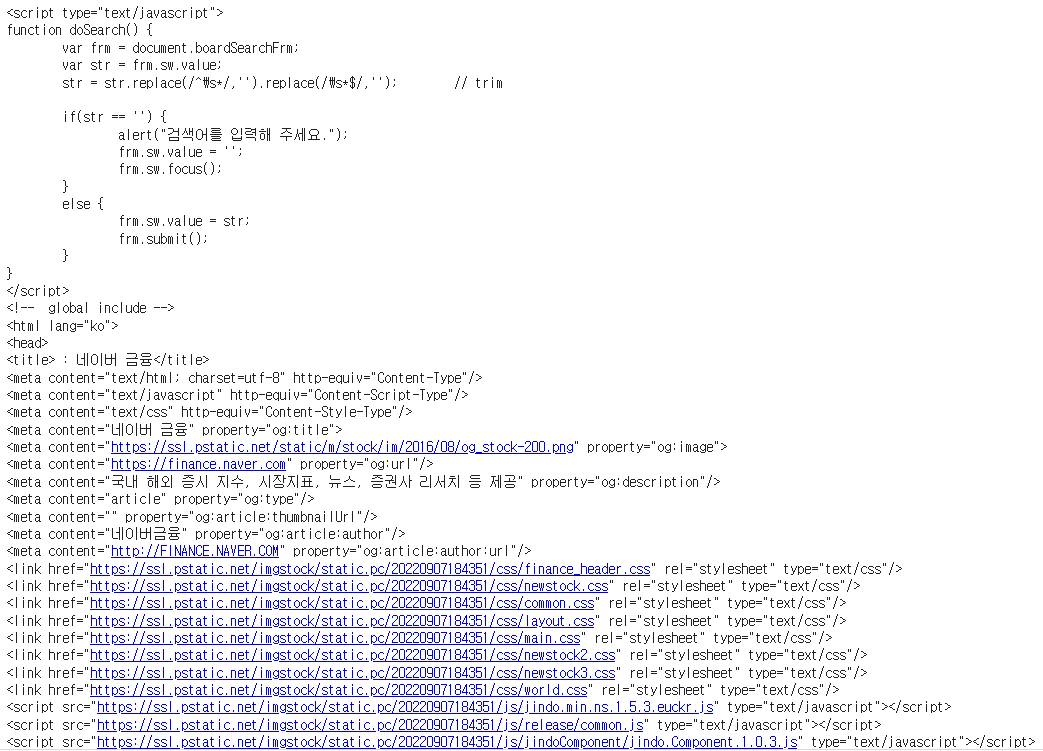

#### **2.1 게시글 제목 태그 찾기**

In [24]:
table = board_soup.find('table', {'class' : 'type2'})
table

<table cellspacing="0" class="type2" summary="종목 토론실의 게시판 글 목록입니다.">
<caption>종목 토론실 게시판</caption>
<colgroup>
<col width="103"/>
<col width="*"/>
<col width="65"/>
<col width="34"/>
<col width="34"/>
<col width="54"/>
</colgroup>
<tbody>
<tr>
<th>날짜</th>
<th>제목</th>
<th>글쓴이</th>
<th>조회</th>
<th>공감</th>
<th>비공감</th>
</tr>
<tr><td colspan="7" height="8"></td></tr>
<tr><td colspan="7" height="5"></td></tr>
</tbody>
</table>

#### **2.2 tbody에서 tr로 이동**
* tbody[0]: 날짜, 제목, 글쓴이, 조회, 등... 열이름
* tbody[1]: 줄간격
* tbody[2]부터 글 제목

In [25]:
board_list=[]
pages = 12 # 종목당 10페이지 크롤링

for page in range(1, pages):
    board_url = 'https://finance.naver.com/item/board.naver?code=%s&page=%s' % (101670, str(page))  # 코리아에스이
    headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}
    
    # html 파싱
    board = requests.get(board_url, headers=headers)
    board_soup = bs(board.text, 'html.parser')
    
    table = board_soup.find('table', {'class':'type2'})
    tbody = table.select('tbody > tr')  # = table.select('tbody tr')
    
    for i in range(2, len(tbody)):   # for 문 글넘어가면서 반복
        if len(tbody[i].select('td > span')) > 0:  # 중간중간에 게시글 5개마다 나누는 선이 있음. 걔는 len=0임
            date = tbody[i].select('td > span')[0].text # 작성 날짜 
            title = tbody[i].select('td.title a')[0]['title']  # 글 제목
            user_id = tbody[i].select('td.p11')[0].text.strip() # 작성자 아이디. strip(): 공백 제거
            views = tbody[i].select('td > span')[1].text # 조회수
            good = tbody[i].select('td > strong')[0].text # 공감
            bad = tbody[i].select('td > strong')[1].text # 비공감
        
            tmp_row = {'날짜': date,
                       '글 제목' : title,
                       '작성자 ID' : user_id,
                       '조회수' : views,
                       '공감' : good,
                       '비공감' : bad
                      }
            
        if tmp_row in board_list:  # 중복 입력된 게시글 삭제
                board_list.remove(tmp_row)
        
        if '2022.09.0' in date:   # 9월 것만
                board_list.append(tmp_row)
        # feature와 데이터로 묶인 딕셔너리 tmp_row를 데이터프레임에 추가
    
pd.DataFrame(board_list)

,날짜,글 제목,작성자 ID,조회수,공감,비공감
0,2022.09.09 23:53,머야 코스닥이네 허걱 관리종목,thks****,504,4,12
1,2022.09.09 22:03,소고기,jack****,235,5,1
2,2022.09.09 21:49,리튬 총사령관 등극,b002****,322,7,3
3,2022.09.09 20:27,병용하는 이유,iamt****,319,1,2
4,2022.09.09 20:25,피신 중 ㅋㅋㅋㅋㅋㅋ,iamt****,270,0,3
...,...,...,...,...,...,...
153,2022.09.07 12:34,호들갑들 떨지 말고 냉정하게 보자.,ssuy****,275,2,3
154,2022.09.07 12:30,ㄴ ㅓ ㄱ ㅓ 덜 ㅇ ㅏ 직도 안잡았니?,tpwl****,220,6,0
155,2022.09.07 12:28,즐거운 거래정지,557e****,229,5,0
156,2022.09.07 12:25,지금,real****,245,2,0


#### **2.3 주주들에게 비공감을 많이 사고 조회수도 높은 글**
= 어그로를 잘 끌은 게시글의 제목

In [26]:
gab_rank1 = pd.DataFrame(board_list)
gab_rank1.sort_values(by = ['비공감', '조회수'], ascending=False)

,날짜,글 제목,작성자 ID,조회수,공감,비공감
103,2022.09.07 17:53,추석쉬고 100% 처박는다,dmk2****,442,4,9
16,2022.09.09 15:10,꼭. 거래정지 다음 거래일에,thks****,504,4,8
37,2022.09.08 19:44,수익률 320% 8410주,ljw0****,417,2,8
46,2022.09.08 15:40,화요일은 쩜상한가,b120****,358,16,8
34,2022.09.08 20:53,찬티 OOO 뿐이군,blue****,275,2,8
...,...,...,...,...,...,...
95,2022.09.07 19:59,.요즘 지인에 인사가ㅡㅡ자네 거시기아파트 아직안팔렸는가? 작년그시세졸때 머혔어?더...,zuak****,169,0,0
126,2022.09.07 15:07,ㅌㅌㅌ,hot6****,157,0,0
128,2022.09.07 14:50,123,chlw****,157,0,0
149,2022.09.07 12:50,경동인베스트,goju****,156,0,0


### **3. 크롤링한 제목들로 빈도수 높은 단어 찾기**
Okt 사용 !pip install konlpy

In [27]:
!pip install konlpy
from konlpy.tag import Okt
from collections import Counter

okt = Okt()
okt.nouns # 명사 분석
okt.morphs # 형태소 분석

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 90.8 MB/s 
     |████████████████████████████████| 453 kB 64.4 MB/s 


<bound method Okt.morphs of <konlpy.tag._okt.Okt object at 0x7fbe188b9e10>>

In [28]:
okt.morphs(gab_rank1['글 제목'][0])

['머', '야', '코스닥', '이네', '허걱', '관리종목']

In [29]:
gab_title = gab_rank1['글 제목'].tolist()
print(len(gab_title))  # 글 180 개

# joins() 리스트를 하나의 문자열로 만듦
gab_title = ' '.join(gab_title)
print(gab_title)

158
머야 코스닥이네 허걱 관리종목 소고기 리튬 총사령관 등극 병용하는 이유 피신 중 ㅋㅋㅋㅋㅋㅋ 시총 1조 목표임다..  명동사채건물로 오셔 . 보여줄게 주린이 7개월차. 주가 분석. 지난  주가 오르면 카나리 15만원갈때보다  재료크기가더크다 이넘... 하인크코리아랑 비슷해보임. 현재 물건이다?시총 1조까지?홀딩한다? 재료의 크기가 가히 핵폭탄급이다 시총 1조 목표임다.. 꼭. 거래정지 다음 거래일에 ■2023년12월■ 매수 대상 종목, 찬티들 ■KSEㅡ한국의보물■ 햐 물건일쎄 해피 추석 해피 투즈데이 결국리튬 정제기술이 결국리튬 정제기술이 제2 코리아에스이 나노 축 컨셉 좋고 모티브도 왕대박일쎄 앞으로 최소 20배 이상 (최상급 리튬주) ■KSEㅡ하얀석유를 캔다■ 10년에 ㅋㅋ 41000주  밑으로   ㅇ   ㅏ   닥   ㅎ   ㅏ  ㅈ  ㅏ  응? 연이은 적자속 경영권 매각 찬티 OOO 뿐이군 ■K에스이 재평가작업 ■ 아직 정해진게 없다 수익률 320% 8410주 화요일 시초가 시총 1조  목표임다.. 그냥 금양이수화학 이런허접과비교말라 강원도 가는 길   입니다. 2차전지 이수화학은 매일상승.. 3만 근접 ㄷㄷㄷㄷㄷ 잠 오겠나 ?? 긴꼬리.... 화요일은 쩜상한가 코리아 시총 1,600억. 시총 1조3천 돌파한 금양은 3천원에서 한달간 매일상승. 오늘 21,250원 터치.금영.이수화학.주가흐름 참조 주식수 많고.무겁던 금양도 3천원에서 매일상승. 오늘 2만 터치..금영.이수화학..주가흐름 참조해 시작은 추석지나서 지피클럽자본과 리튬  총대장주 등극 후 담주 수 목이나되야 돈생기는데 다음주 화요일 살수있을까 태풍다지나갓고 뭔데 이거 어제 기타법인 상한가매수  물 량은 오늘 보합 좋아 보이네... 올인 2차전지 바도체 업체로 거듭난다 이거 왜 정지죠??? 개웃겨 이런 개중에 개잡주도 참 포르쉐 전기차 세컨차 예약 간다!! 고맙소 ㅎㅎㅎㅎ 점상같아보이네 세력형들님덜 즐거운 한가위되십쇼 태풍지나갔다 팔아라 2000원대에서 사신분들 축하 ■■■뉴스떳다.지피

#### **3.1 단어 정규화**

In [30]:
# POS Tagging
raw_pos_tagged = okt.pos(gab_title, norm=True, stem=True)
print(raw_pos_tagged[:10])

[('머', 'Noun'), ('야', 'Josa'), ('코스닥', 'Noun'), ('이네', 'Josa'), ('허걱', 'Noun'), ('관리종목', 'Noun'), ('소고기', 'Noun'), ('리튬', 'Noun'), ('총사령관', 'Noun'), ('등', 'Noun')]


In [31]:
word_cleaned = []
for word in raw_pos_tagged:
    if not word[1] in ["Josa", "Eomi", "Punctuation", "Foreign"]:
        if (len(word[0]) != 1):
            word_cleaned.append(word[0])
            
print(word_cleaned[:10])

['코스닥', '허걱', '관리종목', '소고기', '리튬', '총사령관', '병용', '하다', '이유', '피신']


In [32]:
result = Counter(word_cleaned)  # 개수 세기
word_dict = dict(result)
# print(word_dict)

In [33]:
# 현재 종토방에 가장 많이 쓰인 키워드
sorted_word_dic = sorted(word_dict.items(), key=lambda x:x[1], reverse=True)
print(sorted_word_dic[:10])

[('리튬', 10), ('하다', 9), ('코리아', 8), ('오늘', 7), ('거래', 6), ('에스', 6), ('1조', 5), ('정지', 5), ('이다', 4), ('오다', 4)]


## ***갭상승 리스트 모두 크롤링**
1. 갭 리스트 1~10위, 9월 2일 글만, 크롤링(큰 리스트 하나 만들어서)
2. 비공감수 1개 이상 글에서 많이 쓰인 단어 찾기(-> 어그로성 글에서 가장 많이 쓰인 단어 확인)

### **1. 9월 8일 갭상승 리스트 1~10위 크롤링**

In [34]:
# 갭상승 종목 Pandas: df
stock_code = list(df['stock_code'])
stock_code

['003580',
 '047920',
 '004910',
 '079810',
 '348370',
 '580026',
 '530061',
 '550064',
 '066970',
 '610016']

In [35]:
board_list=[]
pages = 10 # 종목당 10페이지 크롤링

for code in stock_code:
    for page in range(1, pages):
        board_url = 'https://finance.naver.com/item/board.naver?code=%s&page=%s' % (code, str(page))
        headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36'}

        # html 파싱
        board = requests.get(board_url, headers=headers)
        board_soup = bs(board.text, 'html.parser')

        table = board_soup.find('table', {'class':'type2'})
        tbody = table.select('tbody > tr')  # = table.select('tbody tr')

        for i in range(2, len(tbody)):   # for 문 글넘어가면서 반복
            if len(tbody[i].select('td > span')) > 0:  # 중간중간에 게시글 5개마다 나누는 선이 있음. 걔는 len=0임
                date = tbody[i].select('td > span')[0].text # 작성 날짜 
                title = tbody[i].select('td.title a')[0]['title']  # 글 제목
                user_id = tbody[i].select('td.p11')[0].text.strip() # 작성자 아이디. strip(): 공백 제거
                views = tbody[i].select('td > span')[1].text # 조회수
                good = tbody[i].select('td > strong')[0].text # 공감
                bad = tbody[i].select('td > strong')[1].text # 비공감

                tmp_row = {'날짜': date,
                           '글 제목' : title,
                           '작성자 ID' : user_id,
                           '조회수' : views,
                           '공감' : good,
                           '비공감' : bad
                          }

            if tmp_row in board_list:  # 중복 입력된 게시글 삭제
                board_list.remove(tmp_row)

            # feature와 데이터로 묶인 딕셔너리 tmp_row를 데이터프레임에 추가
            if '2022.09.0' in date:   # 9월 것만
                board_list.append(tmp_row)
            
    
pd.DataFrame(board_list)

,날짜,글 제목,작성자 ID,조회수,공감,비공감
0,2022.09.09 22:06,바이든 수혜주,audw****,384,2,1
1,2022.09.09 21:32,엘비가 곧 코스피로 올거다,samd****,816,5,6
2,2022.09.09 21:14,한방 주식?전체 그룹 재무가?,ljd6****,207,1,1
3,2022.09.09 20:53,FDA승인이네..화욜 점상이네.,st93****,897,25,7
4,2022.09.09 20:46,담주 화욜11000~12000까지 급등합니다!,rema****,486,9,3
...,...,...,...,...,...,...
743,2022.09.07 22:50,쫄음,csf0****,128,1,1
744,2022.09.07 20:54,.,cau3****,150,0,6
745,2022.09.07 20:35,근데 테슬라에 들어가는 물량은 왜 공시가 없죠?,lchp****,479,2,1
746,2022.09.07 20:30,"LG엔솔, 미국 애리조나 공장 건설 계획대로 진행",ljt4****,576,10,2


### **2. 크롤링한 데이터에서 확인하기**
1. 비공감, 조회수 기준 높은 글
2. 비공감이 1 이상인 글에서 많이 쓰인 단어

#### **2.1 비공감, 조회수가 높은 글**

In [36]:
gab_list = pd.DataFrame(board_list)
gab_list.sort_values(by = ['비공감', '조회수'], ascending=False)[:20]

,날짜,글 제목,작성자 ID,조회수,공감,비공감
211,2022.09.08 16:32,시외에 다판다..,ojs4****,642,3,9
51,2022.09.08 18:02,설레발들 오지네..,zozo****,700,3,8
191,2022.09.08 17:36,시외 상잡아서 모해 ?? 금요일 쉬고 월요일 쉬고,pcow****,644,1,8
24,2022.09.09 12:13,화욜에… 연상 갈까요.??,ilgi****,640,5,8
3,2022.09.09 20:53,FDA승인이네..화욜 점상이네.,st93****,897,25,7
602,2022.09.09 14:00,"275,000원 언제가나요?...",jun5****,827,1,7
440,2022.09.08 14:47,엔켐 세력입니다.,otg7****,621,2,7
352,2022.09.09 07:52,일일구 구조대,sjsr****,532,2,7
727,2022.09.08 09:16,한국은 투기장세,roro****,198,1,7
160,2022.09.08 22:22,화요일날,espe****,1531,18,7


In [37]:
# 평균 조회수 이상을 찾아보려 함수 만들어둠
def pd_average(pd_list, feature):
    pd_sum=0
    for i in range(len(pd_list)):
        pd_sum += int(pd_list[feature][i])

    return round(pd_sum / len(pd_list))

pd_average(gab_list, '조회수')

316

#### **2.2 비공감 1이상인 글에서 많이 쓰인 단어 확인**

In [38]:
bad_list = []

for i in range(len(gab_list)):
    if int(gab_list['비공감'][i]) > 0:   # 비공감 1 이상
        bad_list.append(gab_list['글 제목'][i])

bad_list = ' '.join(bad_list)   # joins() 리스트를 하나의 문자열로 만듦

# 단어 정규화 PosTagging
raw_pos_tagged = okt.pos(bad_list, norm=True)  # okt.pos(): 품사 태깅
word_cleaned = []
for word in raw_pos_tagged:
    if not word[1] in ["Josa", "Eomi", "Punctuation", "Foreign"]:  # 품사가 조사, 어미, 문장부호 등이 아니고
        if (len(word[0]) > 1):  # 태그된 단어의 길이가 1 이상이면
            word_cleaned.append(word[0])  # 전처리된 단어를 보관하는 word_cleaned에 추가하기

# 날짜도 거르기
day = ['오늘', '내일', '어제', '그저께', '모레']
for word in word_cleaned:
    if word in day:
        word_cleaned.remove(word)

result = Counter(word_cleaned)  # 개수 세기
word_dic = dict(result)
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)  # key값을 기준, 빈도 높은 순으로 정렬
# lambda word_dic[1]: count 개수 

print(sorted_word_dic[:30])

[('시외', 10), ('상하', 10), ('세력', 9), ('상승', 8), ('엔켐', 8), ('주식', 7), ('급등', 7), ('평단', 7), ('종목', 7), ('추석', 7), ('ㅋㅋㅋ', 7), ('시작', 7), ('매도', 7), ('미국', 7), ('승인', 6), ('삭제', 6), ('화요일', 6), ('프로그램', 6), ('공매', 6), ('입니다', 6), ('유로', 6), ('보니', 5), ('개미', 5), ('이유', 5), ('여기', 5), ('대장', 5), ('매수', 5), ('회사', 5), ('이제', 5), ('조광', 5)]


In [39]:
for i in range(len(gab_list)):
    if 'ㅋㅋㅋ' in gab_list['글 제목'][i]:
        print(gab_list['글 제목'][i])  # 속보가 들어간 글에 조롱이 꽤 있음

■■띨띨하긴ㅋㅋㅋ
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ오진석이 찾습니다
■■띨띨하긴ㅋㅋㅋ
ㅋㅋㅋ 결국은 나의승리
ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ잘가고
야 ㅋㅋㅋ
먼일이고 ㅋㅋㅋㅋㅋㅋ
털린 사람 ㅋㅋㅋ고맙다
야 ㅋㅋㅋ ㅅㅂ
공매 숏커버링 하겠네ㅋㅋㅋ
머선129 ㅋㅋㅋㅋㅋㅋ
ㅋㅋㅋ기
6-7프로먹고 매도한 흑우들 ㅋㅋㅋㅋ
오전에 판 흑두루미들 ㅋㅋㅋㅋㅋ
어제밤에 은값 떨어졌는데 가격봐라 ㅋㅋㅋ
ㅋㅋㅋㅋ유로야 당황했냐 ?
태광산업ㅋㅋㅋㅋㅋㅋ
공매견들아 ㅋㅋㅋㅋㅋ 226이다


### **3. 시각화(워드 클라우드)**

#### **3.1 Import Library**
!pip install wordcloud

In [40]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import matplotlib.pyplot as plt
from PIL import Image

주피터에서는 한글로 워드클라우드 만들기가 잘 되는데
코랩에서 안되는 듯

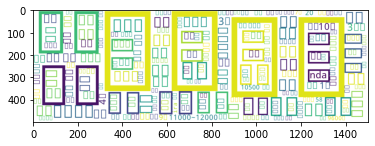

In [41]:
wc = WordCloud(background_color='white',
               width=1500, height=500)
gen = wc.generate_from_frequencies(result)

plt.figure()
plt.imshow(gen)

### 주피터 노트북에서의 결과물
ex) 9월 2일
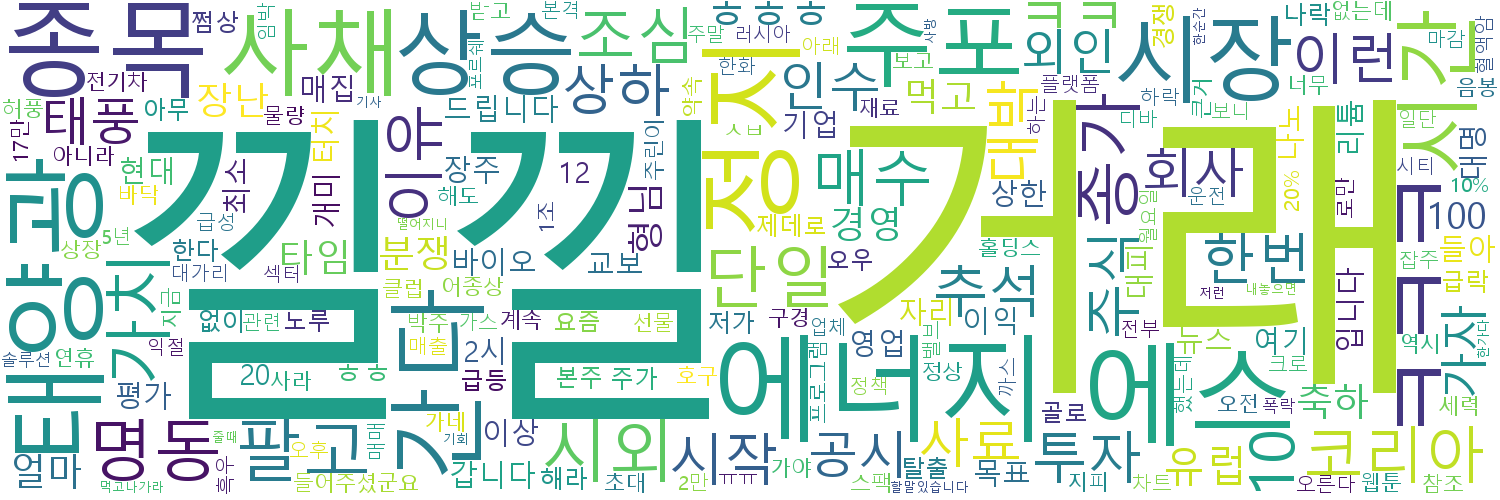